# **SGWB from Hierarchical and Hyperbolic Dynamics of PBHs in Dwarf Galaxies**

### *Code writed by Tadeo D.*  
### In collaboration with Encieh Erfani and Nayeli Marisol Jiménez Cruz








> *"Between gravity and silence, I found your name stitched into the waves."*

**Dedicated to the poetry of my life: Dra. Elizabeth América Flores Frías.**


**References:** [arXiv:2105.14523](https://arxiv.org/pdf/2105.14523.pdf). [arXiv:1603.05234](https://arxiv.org/pdf/1603.05234.pdf)

In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from itertools import combinations, permutations
from itertools import combinations_with_replacement
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
from astropy import constants as cte
from astropy.units import Quantity

In [2]:
c = 299792458 #m/s
c_ast = 299792.458 #km/s
G = 6.6743e-11 #m^3 / (kg s^2)
G_ast = 4.517103049894964e-30 #pc^3 / (s^2 solMass)

In [3]:
# Parámetros del cúmulo
M_DM_cluster = 1e5#1.4e6#1e5#u.Msun 
M_PBH = 10#u.M_sun          
N_PBH_i_Msun = M_DM_cluster / (2 * M_PBH) #Number of PBHs
N_PBH_j_Msun = M_DM_cluster / (2 * M_PBH) #Number of PBHs
N_PBH_total = 2 * N_PBH_i_Msun # Total number of PBHs into cluster
R_cluster = 1.096132 #u.pc

#No estaría mal, implementar un ajuste automatizado.
#Lo haré hoy

print("BOUNDARY CONDITIONS TO CLUSTER")
print(f"Number of PBHs into cluster: {N_PBH_total:.0f} of {M_PBH} Solar Masses")
print(f"Cluster radius (parsecs): {R_cluster:.1f}")

# Radios a evaluar en parsecs (Dividimos el cascaron en 10 cascarones concentricos)
r_values_pc = np.linspace(0.1, R_cluster, 10)

BOUNDARY CONDITIONS TO CLUSTER
Number of PBHs into cluster: 10000 of 10 Solar Masses
Cluster radius (parsecs): 1.1


radius (pc)    n_pbh(r)
0.10           1776
0.21           1656
0.32           1475
0.43           1263
0.54           1048
0.65           848 
0.76           673 
0.87           529 
0.99           412 
1.10           320 


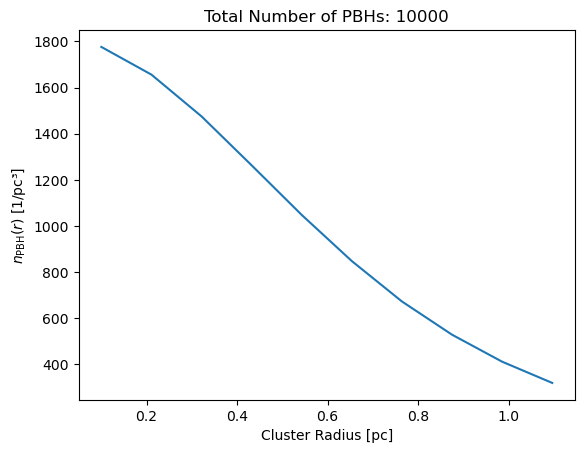

In [4]:
def rho(r):
    factor = (3 * M_DM_cluster) / (4 * np.pi * R_cluster**3)
    shape = 1  + (r / R_cluster)**2
    return factor * shape**(-2.5)

def n_pbh(r, M_pbh):
    #output in (1/u.pc**3)
    return (rho(r) / M_pbh)

# Evaluar densidad numérica en cada radio
n_PBH_r = np.array([
    round(n_pbh(r, M_PBH))
    for r in r_values_pc
])
n_total = np.sum(n_PBH_r)

# Imprimir
print(f"{'radius (pc)':<15}{'n_pbh(r)'}")
print("=" * 24)
for r, n in zip(r_values_pc, n_PBH_r):
    print(f"{r:<15.2f}{n:<4}")

plt.plot(r_values_pc, n_PBH_r)
plt.xlabel("Cluster Radius [pc]")
plt.ylabel("$n_\\mathrm{PBH}(r)$ [1/pc³]")
plt.title(f"Total Number of PBHs: {int(n_total)}")
plt.show()

In [5]:
def phi(r, M_cluster):
    phi_r = ((G_ast * M_cluster / R_cluster) * (1 + (r / R_cluster)**2)**(-0.5))
    phi_r_value = phi_r*9.5214e26 
    #output in (km^2/s^2)
    return phi_r_value

for radius in r_values_pc:
    print(phi(radius, M_DM_cluster))

390.74923700544997
385.3191670414023
376.5236635282478
365.0395257503717
351.63076228294216
337.03435865960034
321.8850809324169
306.6823600732552
291.7891134283598
277.44886626681006


In [6]:
# Función de distribución de energía
def f_E(E, N_pbh, M_cluster):
    E = E/9.5214e26 #.to(u.pc**2 / u.s**2)
    num = 24 * np.sqrt(2) * N_pbh * R_cluster**2 * E**(3.5)
    denom = 7 * np.pi**3 * G_ast**5 * M_cluster**5
    f_E = (num / denom) # s^3 / pc^6
    f_E = f_E*3.404e-41 #(1 / (u.pc**3 * (u.km/u.s)**3))
    return f_E

# Integrando para la velocidad media cuadrática
def integrand(E_val, r, N_pbh, M_cluster):
    # E_val es escalar sin unidades
    E = E_val# * u.km**2 / u.s**2
    phi_val = phi(r, M_cluster)#*(u.km**2 / u.s**2)
    delta_E = (2 * (phi_val - E))#.to((u.km/u.s)**2)
    return (f_E(E, N_pbh, M_cluster) * delta_E**(1.5))#.value  # valor sin unidades


def mean_square_velocity(r, M_cluster, N_pbh, M_pbh):
    n_r = (rho(r) / M_pbh)  # 1/pc^3
    if n_r == 0:
        return 0.0# * u.km / u.s

    phi_r = phi(r, M_cluster)#.to(u.km**2 / u.s**2)

    integral, _ = spi.quad(integrand, 0, phi_r, args=(r, N_pbh, M_cluster))

    v2 = (4 * np.pi / n_r) * integral# * (u.km**2 / u.s**2)
    v = np.sqrt(v2)#.to(u.km / u.s)
    return v#(u.km / u.s)


v_mean_values = np.array([
    mean_square_velocity(r, M_DM_cluster, N_PBH_total, M_PBH)
    for r in r_values_pc
])

for r, v in zip(r_values_pc, v_mean_values):
    print(f"r = {r:.2f},  v_rms = {v:.3f}")

v_0 = np.mean(v_mean_values) #(u.km / u.s)

print(f"\n v0 = {v_0:.3f}")

r = 0.10,  v_rms = 13.978
r = 0.21,  v_rms = 13.881
r = 0.32,  v_rms = 13.721
r = 0.43,  v_rms = 13.511
r = 0.54,  v_rms = 13.260
r = 0.65,  v_rms = 12.982
r = 0.76,  v_rms = 12.687
r = 0.87,  v_rms = 12.384
r = 0.99,  v_rms = 12.079
r = 1.10,  v_rms = 11.779

 v0 = 13.026


In [7]:
# --- Constantes ---
G_SI = 6.67430e-11             # m³ / (kg·s²)
c_SI = 2.99792458e8            # m/s
Msun_kg = 1.98847e30           # kg
pc_m = 3.085677581e16          # m
AU_m = 1.495978707e11          # m
AU_pc = AU_m / pc_m            # 1 AU in pc

# --- r_min for CHES in parsecs (input masses in M_sun) ---
def r_min_CHES(m1, m2, K):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg
    R_sch = lambda m: 2 * G_SI * m / c_SI**2  # Schwarzschild radius in meters
    r_min_m = K * (R_sch(m1_kg) + R_sch(m2_kg))  # meters
    return r_min_m / pc_m  # convert to parsecs

# --- asymptotic velocity in km/s (fully SI-based) ---
def asymptotic_velocity(M_solar, r_min_pc, e=1.1):
    M_kg = M_solar * Msun_kg
    r_min_m = r_min_pc * pc_m  # convert to meters
    v_m_per_s = np.sqrt(((e - 1) * G_SI * M_kg) / r_min_m)
    return v_m_per_s / 1e3  # convert to km/s

r_min_pc = r_min_CHES(M_PBH, M_PBH, 9e5)
r_min_au = r_min_pc / AU_pc  #pc a AU
v_asim = asymptotic_velocity(M_PBH, r_min_pc)

print(f"r_min = {r_min_pc:.3e} pc = {r_min_au:.3e} AU")
print(f"v_asim = {v_0:.1f} km/s")

r_min = 1.723e-06 pc = 3.554e-01 AU
v_asim = 13.0 km/s


In [8]:
# Sección eficaz para formación de binarias (BBH)
def sigma_BPBH(m1, m2, v0):
    v0 = v0 #(u.km / u.s)
    G_astro = G_ast #pc^3 / (s^2 solMass)
    c_astro = c_ast #km/s
    """
    m1, m2: masas en unidades de M_sun
    v0: velocidad relativa en unidades de km/s
    retorna sección eficaz en unidades de pc²
    """
    prefactor = (340 * np.pi / 3)**(2/7)
    num = np.pi * prefactor * G_astro**2 * (m1 + m2)**(10/7) * (m1 * m2)**(2/7)
    denom = c_astro**(10/7) * v0**(18/7)
    sigma_bpbh = (num / denom) * (3.085677581e13)**4 #.to(u.pc**2)
    return sigma_bpbh


# Sección eficaz para encuentros hiperbólicos cercanos (CHES)
def sigma_CHES(m1, m2, v0):
    v0 = v0 #(u.km / u.s)
    G_astro = G_ast #pc^3 / (s^2 solMass)
    c_astro = c_ast #km/s
    """
    m1, m2: masas en M_sun
    v0: velocidad relativa en km/s
    retorna sección eficaz en pc²
    """
    e = 1.01  # valor típico para encuentros no ligados
    b = (G_astro * (m1 + m2) / v0**2) #pc^3/km^2
    b = b/(3.085677581e13**-2)#.to(u.pc)
    sigma_ches = (np.pi * b**2 * (e**2 - 1)) #output pc^2
    return sigma_ches

In [9]:
sigma_bpbh = sigma_BPBH(M_PBH, M_PBH, v_0)
sigma_ches = sigma_CHES(M_PBH, M_PBH, v_0)

print(sigma_bpbh, sigma_ches)

1.7084941891440452e-12 1.6227718870801593e-08


In [10]:
def integrand_I(r_i, r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    km_to_pc = 1 / 3.085677581e13
    n_i = n_pbh(r_i, M_pbh_i) / 2  # [1/pc³]
    v_i = mean_square_velocity(r_i, M_cluster, N_pbh_i, M_pbh_i)*km_to_pc# pc/s
    v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j)*km_to_pc# pc/s
    term = (v_j + v_i)**(3/7) - abs(v_j - v_i)**(3/7) #(pc/s)^3/7
    result = r_i**2 * (n_i / v_i) * term #s^4/7 / pc^11/7
    return result

# Integral I(r_j) con separación de especies i y j
def I_rj(r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    args = (r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster)
    integral, _ = spi.quad(integrand_I, 0.1 * R_cluster, R_cluster, args=args)#[s^4/7 / pc^11/7]
    #Aquí las unidades cambian por las unidades del diferencial que dr tiene unidades de pc
    #[s^4/7 / pc^4/7] 
    return integral 

# Evaluación para todos los radios
I_values = np.array([
    I_rj(r_j, N_PBH_i_Msun, M_PBH, N_PBH_j_Msun, M_PBH, M_DM_cluster)
    for r_j in r_values_pc #[s^4/7 / pc^4/7] 
])

# Ajuste polinomial
coeffs = np.polyfit(r_values_pc, I_values, 3)

# Tasa Gamma considerando especies i y j por separado
def Gamma_rj(r_j, sigma, N_pbh_j, M_pbh_j, M_pbh_i, M_cluster):
    n_j = n_pbh(r_j, M_pbh_j) / 2 # [1/pc³]
    v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j)*km_to_pc#pc/s
    if v_j == 0 or n_j == 0:
        return 0
    I_val = np.polyval(coeffs, r_j)
    result = ((v_0)**18/7)*(14 * np.pi / 3) * sigma * (n_j / v_j) * I_val
    
    return result

In [11]:
# Conversión constante
km_to_pc = 1 / 3.085677581e13  # [pc/km]
v_0_pc = v_0 * km_to_pc        # [pc/s], v_0 ya está definido en tu código

# Integrando de la integral I(r_j)
def integrand_I(r_i, r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    n_i = n_pbh(r_i, M_pbh_i) / 2                          # [1/pc³]
    v_i = mean_square_velocity(r_i, M_cluster, N_pbh_i, M_pbh_i) * km_to_pc  # [pc/s]
    v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j) * km_to_pc  # [pc/s]
    
    term = (v_j + v_i)**(3/7) - abs(v_j - v_i)**(3/7)       # [(pc/s)^(3/7)]
    result = r_i**2 * (n_i / v_i) * term                   # [pc² * (1/pc³) / (pc/s) * (pc/s)^(3/7)]
    # = [s^(-10/7) / pc^(11/7)]
    return result

# Integral I(r_j)
def I_rj(r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    args = (r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster)
    integral, _ = spi.quad(integrand_I, 0.1 * R_cluster, R_cluster, args=args)
    # Resultado: [s^(-10/7) / pc^(4/7)]
    return integral

# Evaluación para todos los radios r_j
I_values = np.array([
    I_rj(r_j, N_PBH_i_Msun, M_PBH, N_PBH_j_Msun, M_PBH, M_DM_cluster)
    for r_j in r_values_pc
])

# Ajuste polinomial en r_j
coeffs = np.polyfit(r_values_pc, I_values, 3)

# Tasa Gamma con todo en pc y s
def Gamma_rj(r_j, sigma, N_pbh_j, M_pbh_j, M_pbh_i, M_cluster):
    n_j = n_pbh(r_j, M_pbh_j) / 2                          # [1/pc³]
    v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j) * km_to_pc  # [pc/s]

    if v_j == 0 or n_j == 0:
        return 0

    I_val = np.polyval(coeffs, r_j)                        # [s^(-10/7) / pc^(4/7)]

    gamma = (v_0_pc)**(18/7) * (14 * np.pi / 3) * sigma * (n_j / v_j) * I_val
    # (pc/s)^(18/7) * pc² * (1/pc³ / pc/s) * [s^(-10/7)/pc^(4/7)]
    
    return gamma     # [1/s]


In [12]:
Gamma_BBH_values = np.array([
    Gamma_rj(r_j, sigma_bpbh, N_PBH_j_Msun, M_PBH, M_PBH, M_DM_cluster)
    for r_j in r_values_pc
])

Gamma_CHES_values = np.array([
    Gamma_rj(r_j, sigma_ches, N_PBH_j_Msun, M_PBH, M_PBH, M_DM_cluster)
    for r_j in r_values_pc
])

## First Generation

> *"In the silence of the early cosmos, they were born —  
> not of stars, but of solitude; destined to meet  
> where light cannot speak."*

In [13]:
# Edad del universo
age_universe_Gyr = 13.786885302009708  # Gyr
age_universe_yr = age_universe_Gyr * 1e9  # yr

# Conversión de tasas a unidades por año
seconds_per_year = 3.15576e7  # s/yr
Gamma_values_yr = Gamma_BBH_values * seconds_per_year
Gamma_CHES_values_yr = Gamma_CHES_values * seconds_per_year

# Número de fusiones esperadas en la edad del universo
#mergers_total = Gamma_values_yr * age_universe_yr

# Tiempo estimado hasta la primera fusión (en años y luego Gyr)
time_first_merger_yr = 1 / Gamma_values_yr
time_first_merger_Gyr = time_first_merger_yr / 1e9

# Tiempo estimado para el primer CHEs
time_first_ches_yr = 1 / Gamma_CHES_values_yr
time_first_ches_Gyr = time_first_ches_yr / 1e9


# Imprimir resultados
#print(f"{'r_j (pc)':<12}{'Gamma (yr^-1)':<15}{'T_merger in UT':<17}{'Time to 1st merger (Gyr)'}")
print(f"{'Gamma_BPBH(yr^-1)':<20}{'Time to 1st merger (Gyr)':<28}{'Gamma_CHES(yr^-1)':<20}{'Time to 1st CHEs (yr)':<28}")
print("=" * 90)
for i in range(len(r_values_pc)):
#    print(f"{r_values_pc[i]:<12.1f}{Gamma_values_yr[i]:<15.3e}{mergers_total[i]:<17.6e}{time_first_merger_Gyr[i]:.3e}")
    print(f"{Gamma_values_yr[i]:<20.3e}{time_first_merger_Gyr[i]:<28.3e}{Gamma_CHES_values_yr[i]:<20.3e}{time_first_ches_yr[i]:.3e}")


Gamma_BPBH(yr^-1)   Time to 1st merger (Gyr)    Gamma_CHES(yr^-1)   Time to 1st CHEs (yr)       
6.886e-11           1.452e+01                   6.540e-07           1.529e+06
6.561e-11           1.524e+01                   6.232e-07           1.605e+06
6.030e-11           1.658e+01                   5.727e-07           1.746e+06
5.354e-11           1.868e+01                   5.085e-07           1.967e+06
4.605e-11           2.172e+01                   4.374e-07           2.286e+06
3.849e-11           2.598e+01                   3.656e-07           2.735e+06
3.136e-11           3.189e+01                   2.978e-07           3.358e+06
2.494e-11           4.009e+01                   2.369e-07           4.221e+06
1.938e-11           5.160e+01                   1.841e-07           5.433e+06
1.468e-11           6.813e+01                   1.394e-07           7.173e+06


In [133]:
time_z_20 = cosmo.age(20).to(u.yr).value
delta_t_merger = (np.min(time_first_merger_yr)/10)# + time_z_20
print(delta_t_merger)
print("time necesary to first merger from Z = 20: ", delta_t_merger/1e9,"Gyr")

delta_t_CHEs = np.min(time_first_ches_yr)# + time_z_20
print("time necesary to first CHEs from Z = 20: ",delta_t_CHEs,"years")



1452317842.003281
time necesary to first merger from Z = 20:  1.4523178420032812 Gyr
time necesary to first CHEs from Z = 20:  1529035.9745616291 years


In [ ]:
# --- Tiempo de evolución ---
#t_final = np.min(time_first_merger_yr)/10  # years

#t_initial = np.min(time_first_ches_yr)# years

#print("Time total to evaluate the first period from Z=20 to t_final (time to the first merger)")
#print(f"T_1st_period = {delta_t_final/1e9:<.9f} Gyr")

#print("\nTime to first CHEs into cluster")
#print(f"T_1st_CHEs = {delta_t_initial/1e9:<.9f} Gyr")
#print(f"T_1st_CHEs = {delta_t_initial:<.3f} yr")

In [ ]:
#time_values_interval = np.linspace(delta_t_initial, delta_t_final, 50) #Gyr
#print(time_values_interval/1e9) #Gyr

In [15]:
# --- Constantes ---
G_SI = 6.67430e-11             # m³ / (kg·s²)
c_SI = 2.99792458e8            # m/s
Msun_kg = 1.98847e30           # kg
pc_m = 3.085677581e16          # m
AU_m = 1.495978707e11          # m
erg_in_joule = 1e-7            # 1 erg = 1e-7 J
AU_pc = AU_m / pc_m            # 1 AU in parsecs
seconds_per_year = 3.15576e7   # s/yr

# --- Parámetros de separación inicial y final ---
a0 = (2 * G_SI * M_PBH * Msun_kg) / c_SI**2 / pc_m   # pc
a1 = 0.1 * AU_pc                                     # pc

# --- Energía radiada BBH ---
def E_rad_GW(m1, m2, a0, a1):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg

    def integrand(a_pc):
        a_m = a_pc * pc_m
        return (G_SI * m1_kg * m2_kg) / (2 * a_m**2) * pc_m  # J

    integral, _ = spi.quad(integrand, a0, a1)
    return integral / erg_in_joule  # erg

# --- Masa final tras fusión BBH ---
def final_mass_GW(m1, m2, a0, a1):
    E_rad = E_rad_GW(m1, m2, a0, a1) * erg_in_joule  # J
    m_total = (m1 + m2) * Msun_kg
    m_final = m_total - E_rad / c_SI**2
    return m_final / Msun_kg  # M_sun

# --- Radio mínimo para CHES (en parsecs) ---
def r_min_CHES(m1, m2, K):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg
    R_sch = lambda m: 2 * G_SI * m / c_SI**2  # m
    return K * (R_sch(m1_kg) + R_sch(m2_kg)) / pc_m  # pc

# --- Energía radiada CHES ---
def E_rad_CHES(m1, m2, e=1.01, K=5):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg
    M = m1_kg + m2_kg
    r_min_m = r_min_CHES(m1, m2, K) * pc_m  # m

    # f(e) factor (Eq. 18)
    term1 = 24 * np.arccos(-1 / e) * (1 + (73/24)*e**2 + (37/96)*e**4)
    term2 = np.sqrt(e**2 - 1) * (301/6 + (673/12)*e**2)
    f_e = (1 / (1 + e)**(7/2)) * (term1 + term2)

    E_rad = (8/15) * G_SI**(3.5) * np.sqrt(M) * m1_kg**2 * m2_kg**2 / (c_SI**5 * r_min_m**(3.5)) * f_e
    return E_rad / erg_in_joule  # erg

In [132]:
# --- Evaluación de energías y masa final ---
E_BBH_event = E_rad_GW(M_PBH, M_PBH, a0, a1)             # erg
E_CHES_event = E_rad_CHES(M_PBH, M_PBH)                  # erg
final_masses = final_mass_GW(M_PBH, M_PBH, a0, a1)       # M_sun

In [219]:
time_values_interval = np.linspace(1e3, delta_t_CHEs, 100) #Years
time_values_interval = np.insert(time_values_interval, 0, 0)
#print(time_values_interval)
t_yr=[]
redshift_evaluated_0 = []
for t in time_values_interval:
    t_yr.append(t + time_z_20)
    t_gyr = (t + time_z_20) / 1e9  # Gyr
    z = z_at_value(cosmo.age, t_gyr * u.Gyr, zmax=25).value
    redshift_evaluated_0.append(z)
print(redshift_evaluated_0)

[20.00000001300767, 19.999921787299087, 19.99871458498963, 19.99750757555089, 19.996300939045888, 19.99509427168051, 19.99388781239898, 19.99268166035725, 19.99147551366575, 19.990269409819245, 19.98906388417771, 19.98785811900601, 19.986652704488865, 19.985447530527185, 19.984242382664913, 19.98303759157042, 19.98183283931544, 19.98062826014313, 19.979424019450878, 19.978219798554445, 19.97701575970373, 19.975811944544457, 19.974608152336412, 19.973404750103928, 19.972201348294625, 19.97099827330127, 19.969795262400538, 19.968592338373764, 19.967389719985363, 19.966187211202232, 19.964984947367903, 19.963782884001997, 19.962580869678604, 19.961379188846188, 19.96017750665353, 19.958976001241254, 19.957774708033565, 19.956573768962553, 19.955372756814064, 19.954171929012137, 19.952971500227047, 19.951770988513, 19.950570792607873, 19.94937084450284, 19.948170817894894, 19.94697114181777, 19.94577158101123, 19.944572323459973, 19.94337312322991, 19.942174009707756, 19.94097513335378, 19

In [284]:
# Si no los tienes, inicialízalos antes del bucle:
N_CHES_0 = np.zeros_like(time_values_interval)
E_dot_CHES_0 = np.zeros_like(time_values_interval)
N_BBH_0 = np.zeros_like(time_values_interval)
E_dot_BBH_0 = np.zeros_like(time_values_interval)
idx_first_all = None
for i, t in enumerate(time_values_interval):
    # CHEs
    Prob_CHES_emit = Gamma_CHES_values_yr * t
    N_CHES = np.round(Prob_CHES_emit * (n_PBH_r / 2))
    #if np.any(N_CHES == 0):
    #    N_CHES = np.zeros_like(Prob_CHES_emit)
    print(N_CHES)
    if np.all(N_CHES > 0) and idx_first_all is None:
        idx_first_all = i
        print("Time necesary to obtain 1 CHEs in all radius of the Cluster:", t, "years")
        print("Time necesary to obtain 1 CHEs in all radius of the Cluster:", t/1e9, "Gyr")
        print("Redshift:", z_at_value(cosmo.age, ((t + time_z_20) / 1e9) * u.Gyr, zmax=25).value)
    N_CHES_tot = np.sum(N_CHES)
    N_CHES_0[i] = N_CHES_tot
    if t==0.:
        E_dot_CHES_shell = 0.
    else:
        E_dot_CHES_shell = (N_CHES_tot * E_CHES_event) / (t * 3.15576e7)
    print(N_CHES_tot, E_dot_CHES_shell)
    E_dot_CHES_shell_tot = np.sum(E_dot_CHES_shell)
    E_dot_CHES_0[i] = E_dot_CHES_shell_tot

    # BBH
    Prob_BPBH_form = Gamma_values_yr * t
    N_BBH = np.where(Prob_BPBH_form * (n_PBH_r/2) > 0.9, np.round(Prob_BPBH_form * (n_PBH_r)), 0.0)
    if np.any(N_BBH == 0):
        N_BBH = np.zeros_like(Prob_BPBH_form)
    N_BBH_tot = np.sum(N_BBH)
    N_BBH_0[i] = N_BBH_tot
    E_dot_BBH_shell = (N_BBH * E_BBH_event) / (t * 3.15576e7)
    #E_dot_BBH_shell_tot = np.sum(E_dot_BBH_shell)
    #E_dot_BBH_0[i] = E_dot_BBH_shell_tot

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0 0.0
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
2.0 7.042972731707923e+41
[10.  8.  7.  5.  4.  3.  2.  1.  1.  0.]
41.0 8.78512422741751e+41
[19. 16. 13. 10.  7.  5.  3.  2.  1.  1.]
Time necesary to obtain 1 CHEs in all radius of the Cluster: 31869.41362750766 years
Time necesary to obtain 1 CHEs in all radius of the Cluster: 3.186941362750766e-05 Gyr
Redshift: 19.99750757555089
77.0 8.50829743339588e+41
[27. 24. 20. 15. 11.  7.  5.  3.  2.  1.]
115.0 8.561007546394746e+41
[36. 32. 27. 20. 14. 10.  6.  4.  2.  1.]
152.0 8.531653380036892e+41
[45. 40. 33. 25. 18. 12.  8.  5.  3.  2.]
191.0 8.60398476147206e+41
[54. 48. 40. 30. 21. 15.  9.  6.  4.  2.]
229.0 8.614843844705975e+41
[63. 56. 46. 35. 25. 17. 11.  7.  4.  2.]
266.0 8.590334295861458e+41
[72. 64. 53. 40. 29. 19. 12.  8.  5.  3.]
305.0 8.628483126655548e+41
[81. 72. 59. 45. 32. 22. 14.  9.  5.  3.]
342.0 8.607876571641574e+41
[90. 80. 66. 50. 36. 24. 16. 10.  6.  3.]
381.0 8.636701815334436e+41
[99. 88

/var/folders/8z/v5ctqgzj6976wfqxw2yn2m1w0000gn/T/ipykernel_1296/1685462506.py:36: RuntimeWarning: invalid value encountered in divide
  E_dot_BBH_shell = (N_BBH * E_BBH_event) / (t * 3.15576e7)


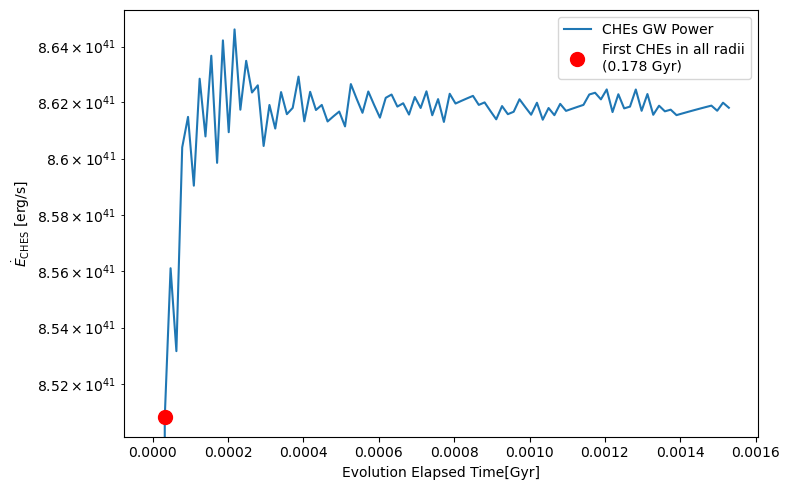

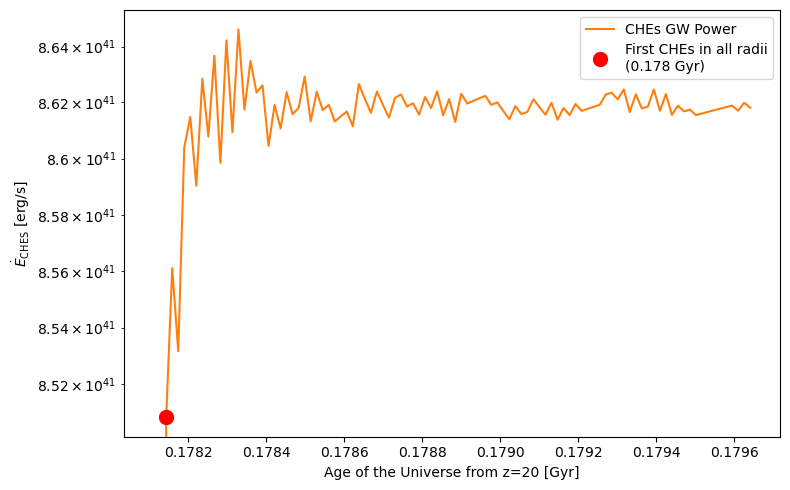

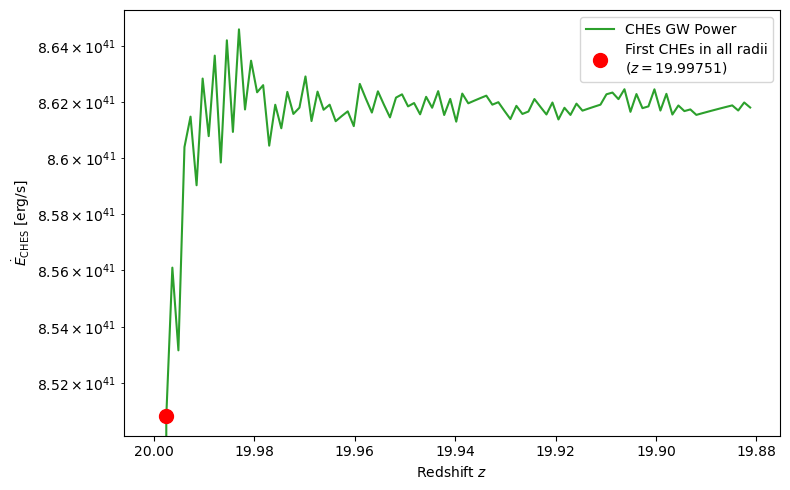

In [248]:
# Recupera los valores críticos
critical_time_yr = time_values_interval[idx_first_all]        # años
critical_time_gyr = critical_time_yr / 1e9                   # Gyr
critical_redshift = redshift_evaluated_0[idx_first_all]
critical_Edot = E_dot_CHES_0[idx_first_all]
critical_abs_age_gyr = (time_z_20 + time_values_interval[idx_first_all]) / 1e9

# --- vs tiempo desde z=20 (en Gyr) ---
plt.figure(figsize=(8,5))
plt.plot(time_values_interval/1e9, E_dot_CHES_0, color='C0', label='CHEs GW Power')
#plt.axvline(critical_time_gyr, color='red', ls='--', lw=2,
#            label=f'First CHEs in all radii\n({critical_time_gyr:.3f} Gyr)')
plt.plot(critical_time_gyr, critical_Edot, 'o', color='red', markersize=10, label=f'First CHEs in all radii\n({critical_abs_age_gyr:.3f} Gyr)')
plt.xlabel('Evolution Elapsed Time[Gyr]')
plt.ylabel(r'$\dot{E}_{\mathrm{CHES}}$ [erg/s]')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# --- vs edad absoluta (en Gyr) ---
plt.figure(figsize=(8,5))
plt.plot((time_z_20+time_values_interval)/1e9, E_dot_CHES_0, color='C1', label='CHEs GW Power')
#plt.axvline(critical_abs_age_gyr, color='red', ls='--', lw=2,
#            label=f'First CHEs in all radii\n({critical_abs_age_gyr:.3f} Gyr)')
plt.plot(critical_abs_age_gyr, critical_Edot, 'o', color='red', markersize=10, label=f'First CHEs in all radii\n({critical_abs_age_gyr:.3f} Gyr)')
plt.xlabel('Age of the Universe from z=20 [Gyr]')
plt.ylabel(r'$\dot{E}_{\mathrm{CHES}}$ [erg/s]')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# --- vs redshift ---
plt.figure(figsize=(8,5))
plt.plot(redshift_evaluated_0, E_dot_CHES_0, color='C2', label='CHEs GW Power')
#plt.axvline(critical_redshift, color='red', ls='--', lw=2,
#            label=f'First CHEs in all radii\n($z={critical_redshift:.2f}$)')
plt.plot(critical_redshift, critical_Edot, 'o', color='red', markersize=10, label=f'First CHEs in all radii\n($z={critical_redshift:.5f}$)')
plt.xlabel('Redshift $z$')
plt.ylabel(r'$\dot{E}_{\mathrm{CHES}}$ [erg/s]')
plt.yscale('log')
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.show()

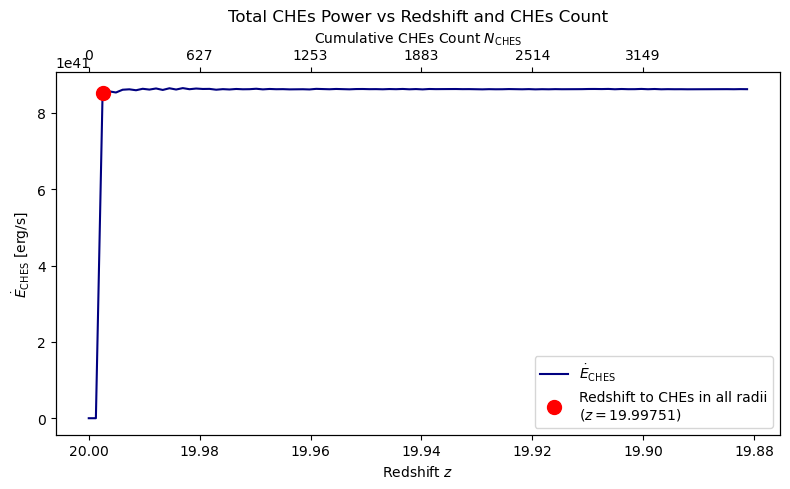

In [283]:
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(redshift_evaluated_0, E_dot_CHES_0, color='navy', label=r'$\dot{E}_{\mathrm{CHES}}$')
#ax1.axvline(critical_redshift, color='red', ls='--', lw=2,
#            label=f'Time necesary to CHEs in all radii\n($z={critical_redshift:.2f}$)')
ax1.plot(critical_redshift, critical_Edot, 'o', color='red', markersize=10, label=f'Redshift to CHEs in all radii\n($z={critical_redshift:.5f}$)')
ax1.set_xlabel('Redshift $z$')
ax1.set_ylabel(r'$\dot{E}_{\mathrm{CHES}}$ [erg/s]')
#ax1.set_yscale('log')
ax1.set_title('Total CHEs Power vs Redshift and CHEs Count')
ax1.invert_xaxis()
ax1.legend()

# Eje x superior: N_CHES_0
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

def tick_function(ticks, redshifts, N_CHES_0):
    ticks_clipped = np.clip(ticks, min(redshifts), max(redshifts))
    return ["%d" % int(np.interp(t, redshifts[::-1], N_CHES_0[::-1])) for t in ticks_clipped]

tick_locs = ax1.get_xticks()
valid_ticks = [t for t in tick_locs if min(redshift_evaluated_0) <= t <= max(redshift_evaluated_0)]
ax2.set_xticks(valid_ticks)
ax2.set_xticklabels(tick_function(valid_ticks, redshift_evaluated_0, N_CHES_0))
ax2.set_xlabel('Cumulative CHEs Count $N_{\mathrm{CHES}}$')

plt.tight_layout()
plt.show()


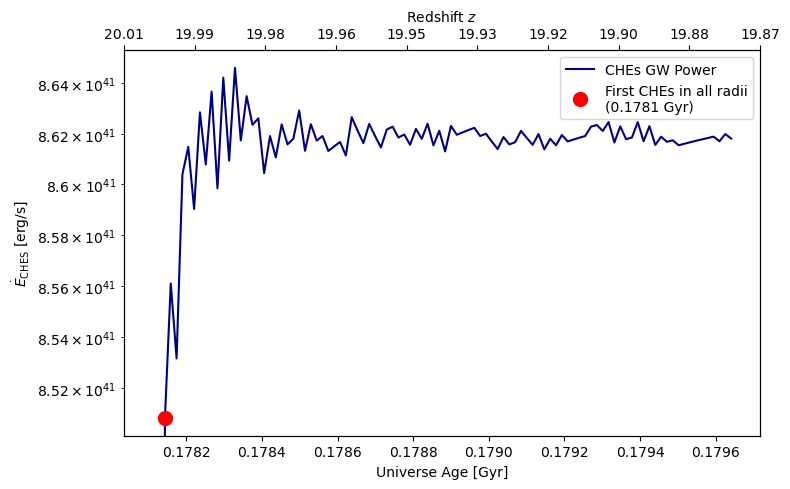

In [281]:
ages_gyr = (time_z_20 + time_values_interval) / 1e9  # Universe Age (Gyr)

fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(ages_gyr, E_dot_CHES_0, color='navy', label='CHEs GW Power')
ax1.plot(critical_abs_age_gyr, critical_Edot, 'o', color='red', markersize=10,
         label=f'First CHEs in all radii\n({critical_abs_age_gyr:.4f} Gyr)')
ax1.set_xlabel('Universe Age [Gyr]')
ax1.set_ylabel(r'$\dot{E}_{\mathrm{CHES}}$ [erg/s]')
ax1.set_yscale('log')
ax1.legend()

# --- Eje x superior: Redshift ---
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

def z_tick_function(ticks):
    # ticks: Universe Age [Gyr]
    labels = []
    for t in ticks:
        try:
            z = z_at_value(cosmo.age, t * u.Gyr, zmax=25).value
            labels.append(f"{z:.2f}")
        except Exception:
            labels.append("")
    return labels

tick_locs = ax1.get_xticks()
ax2.set_xticks(tick_locs)
ax2.set_xticklabels(z_tick_function(tick_locs))
ax2.set_xlabel('Redshift $z$')

plt.tight_layout()
plt.show()

First CHEs event appears at t = 2.0775e+08 yr (z = 17.96)


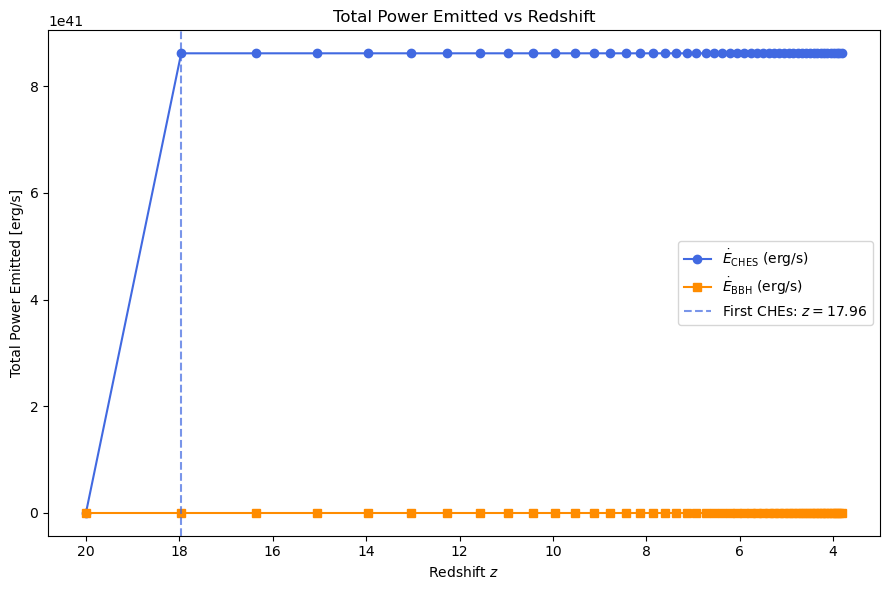

In [112]:
import numpy as np
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
from astropy.cosmology import z_at_value
import matplotlib.pyplot as plt

num_points = 50

# 1. Edad del universo en z=20
t_z20 = cosmo.age(20).to(u.yr).value  # años

# 2. Intervalos de tiempo después de z=20
delta_t = np.linspace(0, delta_t_merger, num_points)  # años después de z=20
t_abs = t_z20 + delta_t                               # edad absoluta, años

dt_intervals = np.diff(delta_t, prepend=delta_t[1] - delta_t[0])

t_abs_gyr = t_abs / 1e9
redshifts = np.array([
    z_at_value(cosmo.age, t * u.Gyr, zmax=25)
    for t in t_abs_gyr
])

N_CHES_0 = np.zeros(num_points)
E_dot_CHES_0 = np.zeros(num_points)
N_BBH_0 = np.zeros(num_points)
E_dot_BBH_0 = np.zeros(num_points)

first_che_idx, first_bbh_idx = None, None

for i in range(num_points):
    dt_interval = dt_intervals[i]
    if dt_interval <= 0:
        continue

    # CHEs
    Prob_CHES_emit = Gamma_CHES_values_yr * dt_interval
    N_CHES = np.round(Prob_CHES_emit * (n_PBH_r / 2))
    N_CHES_tot = np.sum(N_CHES)
    N_CHES_0[i] = N_CHES_tot
    E_dot_CHES_0[i] = (N_CHES_tot * E_CHES_event) / (dt_interval * 3.15576e7) if dt_interval > 0 else 0

    # Marca primer CHEs
    if first_che_idx is None and N_CHES_tot > 0:
        first_che_idx = i
        print(f"First CHEs event appears at t = {t_abs[i]:.4e} yr (z = {redshifts[i]:.2f})")

    # BBH
    Prob_BPBH_form = Gamma_values_yr * dt_interval
    N_BBH = np.where(Prob_BPBH_form * (n_PBH_r / 2) > 0.9, np.round(Prob_BPBH_form * n_PBH_r), 0.0)
    if np.any(N_BBH == 0):
        N_BBH = np.zeros_like(Prob_BPBH_form)
    N_BBH_tot = np.sum(N_BBH)
    N_BBH_0[i] = N_BBH_tot
    E_dot_BBH_0[i] = np.sum(N_BBH * E_BBH_event) / (dt_interval * 3.15576e7) if dt_interval > 0 else 0

    # Marca primer merger
    if first_bbh_idx is None and N_BBH_tot > 0:
        first_bbh_idx = i
        print(f"First BBH merger appears at t = {t_abs[i]:.4e} yr (z = {redshifts[i]:.2f})")

# -- Graficar --
plt.figure(figsize=(9,6))
plt.plot(redshifts, E_dot_CHES_0, marker='o', label=r'$\dot{E}_\mathrm{CHES}$ (erg/s)', color='royalblue')
plt.plot(redshifts, E_dot_BBH_0, marker='s', label=r'$\dot{E}_\mathrm{BBH}$ (erg/s)', color='darkorange')

if first_che_idx is not None:
    plt.axvline(redshifts[first_che_idx], color='royalblue', ls='--', alpha=0.7,
                label=f'First CHEs: $z={redshifts[first_che_idx]:.2f}$')
if first_bbh_idx is not None:
    plt.axvline(redshifts[first_bbh_idx], color='darkorange', ls=':', alpha=0.7,
                label=f'First BBH: $z={redshifts[first_bbh_idx]:.2f}$')

plt.xlabel('Redshift $z$')
plt.ylabel(r'Total Power Emitted [erg/s]')
plt.title(r'Total Power Emitted vs Redshift')
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.show()




First CHEs event appears at t = 0.2078 Gyr (z = 17.96)


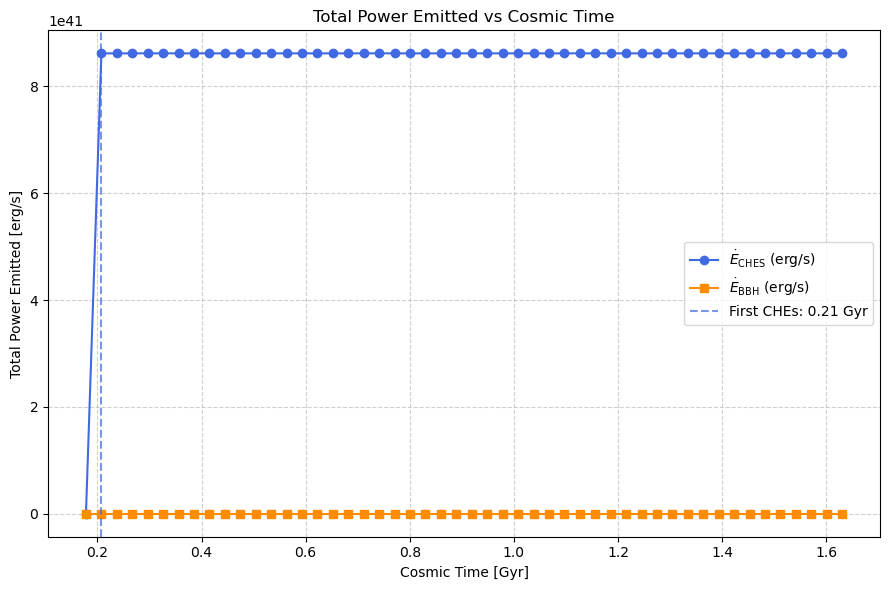

In [114]:
import numpy as np
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
from astropy.cosmology import z_at_value
import matplotlib.pyplot as plt

num_points = 50

# 1. Edad del universo en z=20
t_z20 = cosmo.age(20).to(u.yr).value  # años

# 2. Intervalos de tiempo después de z=20
delta_t = np.linspace(0, delta_t_merger, num_points)  # años después de z=20
t_abs = t_z20 + delta_t                               # edad absoluta, años

dt_intervals = np.diff(delta_t, prepend=delta_t[1] - delta_t[0])

t_abs_gyr = t_abs / 1e9
redshifts = np.array([
    z_at_value(cosmo.age, t * u.Gyr, zmax=25)
    for t in t_abs_gyr
])

N_CHES_0 = np.zeros(num_points)
E_dot_CHES_0 = np.zeros(num_points)
N_BBH_0 = np.zeros(num_points)
E_dot_BBH_0 = np.zeros(num_points)

first_che_idx, first_bbh_idx = None, None

for i in range(num_points):
    dt_interval = dt_intervals[i]
    if dt_interval <= 0:
        continue

    # CHEs
    Prob_CHES_emit = Gamma_CHES_values_yr * dt_interval
    N_CHES = np.round(Prob_CHES_emit * (n_PBH_r / 2))
    N_CHES_tot = np.sum(N_CHES)
    N_CHES_0[i] = N_CHES_tot
    E_dot_CHES_0[i] = (N_CHES_tot * E_CHES_event) / (dt_interval * 3.15576e7) if dt_interval > 0 else 0

    if first_che_idx is None and N_CHES_tot > 0:
        first_che_idx = i
        print(f"First CHEs event appears at t = {t_abs_gyr[i]:.4f} Gyr (z = {redshifts[i]:.2f})")

    # BBH
    Prob_BPBH_form = Gamma_values_yr * dt_interval
    N_BBH = np.where(Prob_BPBH_form * (n_PBH_r / 2) > 0.9, np.round(Prob_BPBH_form * n_PBH_r), 0.0)
    if np.any(N_BBH == 0):
        N_BBH = np.zeros_like(Prob_BPBH_form)
    N_BBH_tot = np.sum(N_BBH)
    N_BBH_0[i] = N_BBH_tot
    E_dot_BBH_0[i] = np.sum(N_BBH * E_BBH_event) / (dt_interval * 3.15576e7) if dt_interval > 0 else 0

    if first_bbh_idx is None and N_BBH_tot > 0:
        first_bbh_idx = i
        print(f"First BBH merger appears at t = {t_abs_gyr[i]:.4f} Gyr (z = {redshifts[i]:.2f})")

# -- Graficar --
plt.figure(figsize=(9,6))
plt.plot(t_abs_gyr, E_dot_CHES_0, marker='o', label=r'$\dot{E}_\mathrm{CHES}$ (erg/s)', color='royalblue')
plt.plot(t_abs_gyr, E_dot_BBH_0, marker='s', label=r'$\dot{E}_\mathrm{BBH}$ (erg/s)', color='darkorange')

if first_che_idx is not None:
    plt.axvline(t_abs_gyr[first_che_idx], color='royalblue', ls='--', alpha=0.7,
                label=f'First CHEs: {t_abs_gyr[first_che_idx]:.2f} Gyr')
if first_bbh_idx is not None:
    plt.axvline(t_abs_gyr[first_bbh_idx], color='darkorange', ls=':', alpha=0.7,
                label=f'First BBH: {t_abs_gyr[first_bbh_idx]:.2f} Gyr')

plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel(r'Total Power Emitted [erg/s]')
plt.title(r'Total Power Emitted vs Cosmic Time')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.tight_layout()
plt.show()


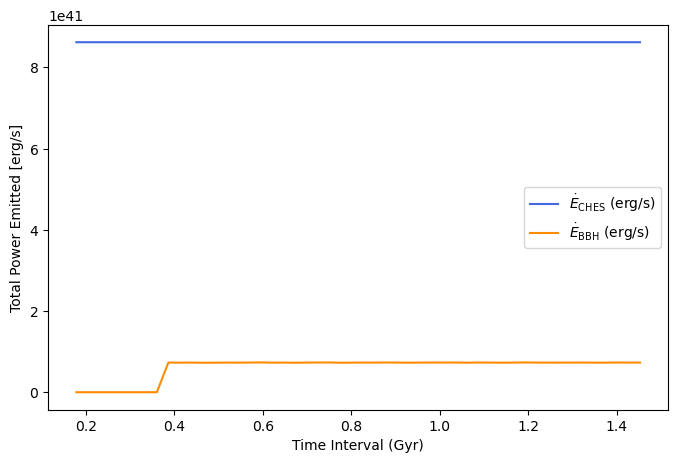

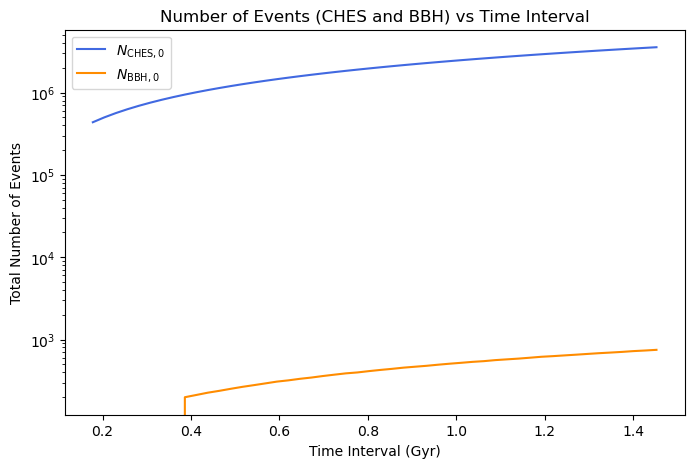

In [89]:
# Eje x en Gyr
x_gyr = time_values_interval/1e9

# -------- Gráfica de Potencia Total (CHES y BBH) --------
plt.figure(figsize=(8,5))
plt.plot(x_gyr, E_dot_CHES_0, label=r'$\dot{E}_\mathrm{CHES}$ (erg/s)', color='royalblue')
plt.plot(x_gyr, E_dot_BBH_0, label=r'$\dot{E}_\mathrm{BBH}$ (erg/s)', color='darkorange')
plt.xlabel('Time Interval (Gyr)')
plt.ylabel(r'Total Power Emitted [erg/s]')
#plt.title(r'Total Power Emitted by CHES and BBH vs Time Interval')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()
#plt.grid(True, which='both', ls='--', alpha=0.6)
#plt.tight_layout()
plt.show()

# -------- Gráfica de Números de Eventos Totales --------
plt.figure(figsize=(8,5))
plt.plot(x_gyr, N_CHES_0, label=r'$N_\mathrm{CHES,0}$', color='royalblue')
plt.plot(x_gyr, N_BBH_0, label=r'$N_\mathrm{BBH,0}$', color='darkorange')
plt.xlabel('Time Interval (Gyr)')
plt.ylabel('Total Number of Events')
plt.title(r'Number of Events (CHES and BBH) vs Time Interval')
plt.yscale('log')
plt.legend()
plt.show()


In [ ]:
# --- Evaluación de energías y masa final ---
# E_BBH_event = E_rad_GW(M_PBH, M_PBH, a0, a1)             # erg
# E_CHES_event = E_rad_CHES(M_PBH, M_PBH)                  # erg
# final_masses = final_mass_GW(M_PBH, M_PBH, a0, a1)       # M_sun

#for t in time_values_interval:
#    --- delta_t en segundos ---
#    delta_t_sec = t * 1e9 * seconds_per_year
#    Prob_BPBH_form = Gamma_values_yr * t       # adimensional
#    Prob_CHES_emit = Gamma_CHES_values_yr * t  # adimensional
#    Número esperado de colisiones por cascarón
#    N_collisions = np.where(Prob_BPBH_form * (n_PBH_r/2) > 0.9, np.round(Prob_BPBH_form * (n_PBH_r)), 0.0)#np.round(Prob_BPBH_form * (n_PBH_r))  # array
#    N_CHES = np.round(Prob_CHES_emit * (n_PBH_r/2))
#    --- Potencias totales por cascarón ---
#    E_dot_BBH_shell = N_collisions * E_BBH_event / delta_t_sec  # erg/s
#    E_dot_CHES_shell = N_CHES * E_CHES_event / delta_t_sec      # erg/s# --- Imprimir resultados ---
#    print(f"Time to evaluate{t/1e9:<.9f} Gyr")
#    print(f"{'n_PBH(r)':<15}{'N_collisions':<18}{'E_dot_GW_BPBH':<18}{'N_CHES':<14}{'E_dot_CHES':<10}")
 #   print("=" * 80)
 #   for i in range(len(r_values_pc)):
  #      print(f"{n_PBH_r[i]:<15.1f}{N_collisions[i]:<18.1f}{E_dot_BBH_shell[i]:<18.4e}{N_CHES[i]:<14.1f}{E_dot_CHES_shell[i]:<10.8e}")
        
   # print("\n")
#print(f"Final Mass = {final_masses:.1f} M_sun")

In [ ]:
#print(E_dot_CHES_shell)

In [ ]:
# --- Probabilidades de formación/emisión en ese intervalo ---
#Prob_BPBH_form = Gamma_values_yr * delta_t       # adimensional
#Prob_CHES_emit = Gamma_CHES_values_yr * delta_t  # adimensional

# Número esperado de colisiones por cascarón
#N_collisions = np.where(Prob_BPBH_form * (n_PBH_r/2) > 0.9, np.round(Prob_BPBH_form * (n_PBH_r)), 0.0)#np.round(Prob_BPBH_form * (n_PBH_r))  # array
#N_CHES = np.round(Prob_CHES_emit * (n_PBH_r/2))
# --- Imprimir resultados ---
#print(f"{'Gamma (yr^-1)':<15}{'n_PBH(r)':<15}{'N_collisions':<18}{'N_CHES':<10}")
#print("=" * 60)
#for i in range(len(r_values_pc)):
#    print(f"{Gamma_values_yr[i]:<15.3e}{n_PBH_r[i]:<15.1f}{N_collisions[i]:<18.1f}{N_CHES[i]:<10.1f}")

In [ ]:
# --- Gráfica de potencias radiadas ---
plt.plot(r_values_pc, E_dot_CHES_shell, label='CHES', linewidth=2, linestyle='-')
plt.plot(r_values_pc, E_dot_BBH_shell, label='BPBH', linewidth=2, linestyle='--')


plt.xlabel("Radius (pc)", fontsize=12)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.1,1.0])
plt.legend([
    r"CHEs from $M_{\rm PBH} = 10\, M_{\odot}$",
    r"Binaries of PBHs from $M_{\rm PBH} = 10\, M_{\odot}$"
], 
loc='best', ncol=1, frameon=True)

#plt.title("Total Power Radiated from BPBH and CHES", fontsize=14)


plt.tight_layout()
plt.savefig("BPBH&CHES.pdf", dpi=300, bbox_inches="tight")
plt.show()




## Second Generation
> *"Bound not by threads, but by gravity's gaze,  
> they embraced through the void, weaving echoes  
> into the fabric of time."*

In [ ]:
N_PBH_1G = np.sum(N_collisions) #PBHs de primera generación
M_PBH_1G = final_masses 
M_PBH_0G = M_PBH 
M_1G = N_PBH_1G * M_PBH_1G 
N_PBH_0G = n_total - (2*N_PBH_1G)
M_tot_0G = N_PBH_0G*M_PBH #masa total de los PBHs_0G que contribuyen a la masa total del cluster
M_DM_c_1G = M_tot_0G + M_1G #masa total del cluster para la 1G
M_LOST_GW = 1e5 - M_DM_c_1G #cantidad de masa perdida por emisión de ondas gravitacionales de binarias
percent_lost_GW = (M_LOST_GW / M_DM_cluster) * 100

print(f"Number of PBHs of initial generation: {N_PBH_0G:.0f} of {M_PBH_0G:.2f} Solar Mass")
print(f"Number of PBHs of 1st generation:     {N_PBH_1G:.0f} of {M_PBH_1G:.2f} Solar Mass")
print(f"Cluster Mass after 1st generation:    {M_DM_c_1G:.4e} Solar Mass")
print(f"Mass lost by GWs (BPBH mergers):       {M_LOST_GW:.4f} Solar Mass")
print(f"Percentage of Cluster Mass Lost by GWs: {percent_lost_GW:.1f}%")



In [ ]:
M_DM_cluster = M_DM_c_1G

N_0G = n_PBH_r - 2 * N_collisions
N_1G = N_collisions

#print(N_0G, N_1G)
#print(np.sum(N_0G), np.sum(N_1G))

from itertools import combinations_with_replacement

# --- Definir las especies con sus arrays de número por cascarón ---
especies = [
    {"name": "0G", "N_array": N_0G, "M": M_PBH},
    {"name": "1G", "N_array": N_1G, "M": final_masses}
]

#n_PBH_r - 2 * N_collisions#, N_collisions)

# --- Generar combinaciones con reemplazo: (0G–0G, 0G–1G, 1G–1G) ---
combinaciones_preparadas = []

for sp_i, sp_j in combinations_with_replacement(especies, 2):
    nombre_i, N_i_array, M_i = sp_i["name"], sp_i["N_array"], sp_i["M"]
    nombre_j, N_j_array, M_j = sp_j["name"], sp_j["N_array"], sp_j["M"]

    # Si son de la misma especie (0G–0G o 1G–1G), dividir a la mitad
    if nombre_i == nombre_j:
        N_i_array = np.round(N_i_array / 2)
        N_j_array = np.round(N_j_array / 2)

    combinaciones_preparadas.append((nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j))

def evaluar_I_rj_por_combinacion(N_i, M_i, N_j, M_j, M_cluster):
    """
    Calcula I(r_j) para cada cascarón y devuelve sus coeficientes polinomiales.
    Los parámetros N_i y N_j pueden ser escalares (sumas por especie).
    """
    I_values = np.array([
        I_rj(r_j, N_i, M_i, N_j, M_j, M_cluster)
        for r_j in r_values_pc
    ])
    coeffs = np.polyfit(r_values_pc, I_values, 3)
    return I_values, coeffs

# --- Nueva función para Gamma usando arrays discretos ---
def Gamma_rj_discreto(j, r_j, sigma, N_j_array, M_j, M_i, M_cluster, coeffs):
    n_j = N_j_array[j]  # número de PBHs tipo j en el cascarón j
    v_j = mean_square_velocity(r_j, M_cluster, N_j_array[j], M_j) * km_to_pc  # [pc/s]

    if v_j == 0 or n_j == 0:
        return 0

    I_val = np.polyval(coeffs, r_j)  # [s^(-10/7) / pc^(4/7)]

    gamma = (v_0_pc)**(18/7) * (14 * np.pi / 3) * sigma * (n_j / v_j) * I_val
    return gamma  # [1/s]

# --- Evaluación por cada combinación de especies ---
resultados_discretos = []

E_dot_BBH_dict = {}
E_dot_CHES_dict = {}
M_dict = {}
N_coll_BPBH_dict = {}
N_coll_CHES_dict = {}

for nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j in combinaciones_preparadas:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")


    # ----------------------
    # --- BBH CALCULATIONS --
    # ----------------------
    sigma_B = sigma_BPBH(M_i, M_j, v_0)

    I_vals, coeffs_ij = evaluar_I_rj_por_combinacion(np.sum(N_i_array), M_i, np.sum(N_j_array), M_j, M_DM_cluster)

    Gamma_values = np.array([
        Gamma_rj_discreto(j, r_values_pc[j], sigma_B, N_j_array, M_j, M_i, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])
    Gamma_values_yr = Gamma_values * seconds_per_year
    mergers_total = Gamma_values_yr * age_universe_yr
    time_first_merger_yr = 1 / Gamma_values_yr
    time_first_merger_Gyr = time_first_merger_yr / 1e9

    # Tiempo característico
    delta_t_local = 3e9#np.min(time_first_merger_yr) / 10

    # Colisiones BBH
    Prob_form = Gamma_values_yr * delta_t_local
    N_coll_BBH = np.where(Prob_form * N_i_array > 0.9, np.round(Prob_form * N_i_array), 0.0) #np.round(Prob_form * N_i_array)
    M_result = final_mass_GW(M_i, M_j, a0, a1)
    M_dict[f"{nombre_i}-{nombre_j}"] = M_result

    # Energía BBH
    E_BBH_event = E_rad_GW(M_i, M_j, a0, a1)
    E_dot_BBH = N_coll_BBH * E_BBH_event / delta_t_sec

    # ------------------------
    # --- CHES CALCULATIONS --
    # ------------------------
    G_ast = 4.517103049894964e-30  # pc³ / (s² M_sun)
    c_ast = 2.99792458e5           # km/s
    e = 1.01
    K = 10
    b = (G_ast * (M_i + M_j) / v_0**2) / (1 / (3.085677581e13)**2)
    sigma_C = np.pi * b**2 * (e**2 - 1)

    Gamma_CHES = np.array([
        Gamma_rj_discreto(j, r_values_pc[j], sigma_C, N_j_array, M_j, M_i, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])
    Gamma_CHES_yr = Gamma_CHES * seconds_per_year
    Prob_emit = Gamma_CHES_yr * delta_t_local
    N_coll_CHES = np.round(Prob_emit * N_i_array)

    E_CHES_event = E_rad_CHES(M_i, M_j, e, K)
    E_dot_CHES = N_coll_CHES * E_CHES_event / delta_t_sec

    # ------------------------
    # --- Print Tab --
    # ------------------------
    print(f"Masses interacting")
    print(f"M_PBH_{nombre_i}: {M_i:.2f}")
    print(f"M_PBH_{nombre_j}: {M_j:.2f}")
    print(f"Mass_final_from_{nombre_i}-{nombre_j}: {M_dict[f'{nombre_i}-{nombre_j}']:.2f}")
    print(f"\n{'r_j (pc)':<10}{'Γ_BBH (yr^-1)':<15}{'Γ_CHES (yr^-1)':<17}"
          f"{'T_1st merge (Gyr)':<20}{'N_BBH':<10}{'N_CHES':<10}")
    print("=" * 80)
    for i in range(len(r_values_pc)):
        print(f"{r_values_pc[i]:<10.2f}"
              f"{Gamma_values_yr[i]:<15.3e}"
              f"{Gamma_CHES_yr[i]:<17.3e}"
              f"{time_first_merger_Gyr[i]:<20.3e}"
              f"{N_coll_BBH[i]:<10.1f}"
              f"{N_coll_CHES[i]:.1f}")
    
    #Discret_results
    N_coll_BPBH_dict[f"{nombre_i}-{nombre_j}"] = N_coll_BBH
    N_coll_CHES_dict[f"{nombre_i}-{nombre_j}"] = N_coll_CHES
    E_dot_BBH_dict[f"{nombre_i}-{nombre_j}"] = E_dot_BBH
    E_dot_CHES_dict[f"{nombre_i}-{nombre_j}"] = E_dot_CHES


    # ----------------------------
    # --- Summary 
    # ----------------------------
    print(f"\n[Resumen {nombre_i}-{nombre_j}]")
    #print(f"Σ_BBH = {sigma_B:.2e} pc²")
    #print(f"Σ_CHES = {sigma_C:.2e} pc²")
    #print(f"E_BBH per event = {E_BBH_event:.2e} erg")
    #print(f"E_CHES per event = {E_CHES_event:.2e} erg")
    print(f"Total BBH events = {int(np.sum(N_coll_BBH))}")
    #print(f"Total CHES events = {int(np.sum(N_coll_CHES))}")
    #print(f"P_BBH radiated = {np.sum(E_dot_BBH):.2e} erg/s")
    #print(f"P_CHES radiated = {np.sum(E_dot_CHES):.2e} erg/s")

    # --- Save Results ---
    resultados_discretos.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Gamma_values_yr": Gamma_values_yr,
        "Mass_final": M_result,
        "N_collisions_BBH": N_coll_BBH,
        "N_collisions_CHES": N_coll_CHES,
        "E_event_BBH": E_BBH_event,
        "E_event_CHES": E_CHES_event,
        "E_dot_BBH": E_dot_BBH,
        "E_dot_CHES": E_dot_CHES,
        "sigma_BBH": sigma_B,
        "sigma_CHES": sigma_C
    })

In [ ]:
#print(E_dot_CHES_dict["0G-0G"])
plt.figure(figsize=(10, 6))
plt.loglog(r_values_pc, E_dot_CHES_shell, label='CHES 0G-0G (1st Period)', linewidth=2, linestyle='solid')
for key in E_dot_CHES_dict:
    plt.loglog(r_values_pc, E_dot_CHES_dict[key], linestyle="solid", label=f"CHES {key} (2nd Period)")
plt.xlabel("Radius (pc)", fontsize=12)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.legend()
plt.xlim([0.1,1.0])
plt.savefig("CHES_2.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
for key in E_dot_BBH_dict:
    plt.plot(r_values_pc, E_dot_CHES_dict[key], linestyle="solid", label=f"CHES {key}")
    plt.plot(r_values_pc, E_dot_BBH_dict[key], linestyle="--",label=f"BPBH {key}")
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("Radius (pc)", fontsize=12)
    plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
    plt.legend()
    plt.xlim([0.1,1.0])
    filename = f"BPBH_CHES_{key.replace('–', '-')}.pdf"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

## Third Generation
> *"Each collision a verse, each merger a vow — shaping the darkness into rhythm, into memory, into mass."*


In [ ]:
M_0G = M_PBH_0G #Masa de la población original
M_1G = resultados_discretos[0]['Mass_final'] #Masa resultante de 0G-0G.
M_2G_a = resultados_discretos[1]['Mass_final'] #Masa resultante de 0G-1G
M_2G_b = resultados_discretos[2]['Mass_final'] #Masa resultante de 1G-1G

N_2G_b = resultados_discretos[2]['N_collisions_BBH'] #
N_2G_a = resultados_discretos[1]['N_collisions_BBH'] #

#print(N_0G, N_1G)

N_0G_second = N_0G - (2*(resultados_discretos[0]['N_collisions_BBH'])+ N_2G_a)#
#print(np.sum(N_0G_second)*M_0G)
N_1G_second = (N_1G - (N_2G_a + 2*N_2G_b)) + resultados_discretos[0]['N_collisions_BBH'] #
#print(np.sum(N_1G_second)*M_1G)
#print(np.sum(N_2G_a)*M_2G_a)
#print(np.sum(N_2G_b)*M_2G_b)


M_DM_c_2G = (np.sum(N_0G_second)*M_0G) + (np.sum(N_1G_second)*M_1G) + (np.sum(N_2G_a)*M_2G_a) + (np.sum(N_2G_b)*M_2G_b)
M_LOST_GW = M_DM_cluster - M_DM_c_2G #cantidad de masa perdida por emisión de ondas gravitacionales de binarias
percent_lost_GW = (M_LOST_GW / M_DM_cluster) * 100


print(f"Number of PBHs of initial generation: {np.sum(N_0G_second)} of {M_0G:.2f} Solar Mass")
print(f"Number of BHs of 1st generation:     {np.sum(N_1G_second)} of {M_1G:.2f} Solar Mass")
print(f"Number of BHs of 2nd generation_a:   {np.sum(N_2G_a)} of {M_2G_a:.2f} Solar Mass")
print(f"Number of BHs of 2nd generation_b:   {np.sum(N_2G_b)} of {M_2G_b:.2f} Solar Mass")
print(f"Cluster Mass after 2nd generation:    {M_DM_c_2G:.4e} Solar Mass")
print(f"Mass lost by GWs (BPBH mergers):       {M_LOST_GW:.4e} Solar Mass")
print(f"Percentage of Cluster Mass Lost by GWs: {percent_lost_GW:.1f}%")

In [ ]:
M_DM_cluster = M_DM_c_2G

especies = [
    {"name": "0G", "N_array": N_0G_second, "M": M_0G},
    {"name": "1G", "N_array": N_1G_second, "M": M_1G},
    {"name": "2G_a", "N_array": N_2G_a, "M": M_2G_a},
    {"name": "2G_b", "N_array": N_2G_b, "M": M_2G_b},
]

print(N_0G_second)

# --- Generar combinaciones con reemplazo: (0G–0G, 0G–1G, 1G–1G) ---
combinaciones_preparadas = []

for sp_i, sp_j in combinations_with_replacement(especies, 2):
    nombre_i, N_i_array, M_i = sp_i["name"], sp_i["N_array"], sp_i["M"]
    nombre_j, N_j_array, M_j = sp_j["name"], sp_j["N_array"], sp_j["M"]

    # Si son de la misma especie (0G–0G o 1G–1G), dividir a la mitad
    if nombre_i == nombre_j:
        N_i_array = np.round(N_i_array / 2)
        N_j_array = np.round(N_j_array / 2)

    combinaciones_preparadas.append((nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j))

def evaluar_I_rj_por_combinacion(N_i, M_i, N_j, M_j, M_cluster):
    """
    Calcula I(r_j) para cada cascarón y devuelve sus coeficientes polinomiales.
    Los parámetros N_i y N_j pueden ser escalares (sumas por especie).
    """
    I_values = np.array([
        I_rj(r_j, N_i, M_i, N_j, M_j, M_cluster)
        for r_j in r_values_pc
    ])
    coeffs = np.polyfit(r_values_pc, I_values, 3)
    return I_values, coeffs

# --- Nueva función para Gamma usando arrays discretos ---
def Gamma_rj_discreto(j, r_j, sigma, N_j_array, M_j, M_i, M_cluster, coeffs):
    n_j = N_j_array[j]  # número de PBHs tipo j en el cascarón j
    v_j = mean_square_velocity(r_j, M_cluster, N_j_array[j], M_j) * km_to_pc  # [pc/s]

    if v_j == 0 or n_j == 0:
        return 0

    I_val = np.polyval(coeffs, r_j)  # [s^(-10/7) / pc^(4/7)]

    gamma = (v_0_pc)**(18/7) * (14 * np.pi / 3) * sigma * (n_j / v_j) * I_val
    return gamma  # [1/s]

# --- Evaluación por cada combinación de especies ---
resultados_discretos_3rd = []

E_dot_BBH_dict_3 = {}
E_dot_CHES_dict_3 = {}
M_dict_3 = {}
N_coll_BPBH_dict_3 = {}
N_coll_CHES_dict_3 = {}

for nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j in combinaciones_preparadas:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    # ----------------------
    # --- BBH CALCULATIONS --
    # ----------------------
    sigma_B = sigma_BPBH(M_i, M_j, v_0)

    I_vals, coeffs_ij = evaluar_I_rj_por_combinacion(np.sum(N_i_array), M_i, np.sum(N_j_array), M_j, M_DM_cluster)

    Gamma_values = np.array([
        Gamma_rj_discreto(j, r_values_pc[j], sigma_B, N_j_array, M_j, M_i, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])
    Gamma_values_yr = Gamma_values * seconds_per_year
    mergers_total = Gamma_values_yr * age_universe_yr
    time_first_merger_yr = 1 / Gamma_values_yr
    time_first_merger_Gyr = time_first_merger_yr / 1e9

    # Tiempo característico
    delta_t_local = 3e9#np.min(time_first_merger_yr) / 10

    # Colisiones BBH
    Prob_form = Gamma_values_yr * delta_t_local
    N_coll_BBH = np.where(Prob_form * N_i_array > 0.9, np.round(Prob_form * N_i_array), 0.0)#np.round(Prob_form * (N_i_array))
    M_result = final_mass_GW(M_i, M_j, a0, a1)
    M_dict_3[f"{nombre_i}-{nombre_j}"] = M_result

    # Energía BBH
    E_BBH_event = E_rad_GW(M_i, M_j, a0, a1)
    E_dot_BBH = N_coll_BBH * E_BBH_event / delta_t_sec

    # ------------------------
    # --- CHES CALCULATIONS --
    # ------------------------
    G_ast = 4.517103049894964e-30  # pc³ / (s² M_sun)
    c_ast = 2.99792458e5           # km/s
    e = 1.01
    K = 10
    b = (G_ast * (M_i + M_j) / v_0**2) / (1 / (3.085677581e13)**2)
    sigma_C = np.pi * b**2 * (e**2 - 1)

    Gamma_CHES = np.array([
        Gamma_rj_discreto(j, r_values_pc[j], sigma_C, N_j_array, M_j, M_i, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])
    Gamma_CHES_yr = Gamma_CHES * seconds_per_year
    Prob_emit = Gamma_CHES_yr * delta_t_local
    N_coll_CHES = np.round(Prob_emit * (N_i_array))

    E_CHES_event = E_rad_CHES(M_i, M_j, e, K)
    E_dot_CHES = N_coll_CHES * E_CHES_event / delta_t_sec

    # ------------------------
    # --- Print Tab --
    # ------------------------
    print(f"Masses interacting")
    print(f"M_PBH_{nombre_i}: {M_i:.2f}")
    print(f"M_PBH_{nombre_j}: {M_j:.2f}")
    print(f"Mass_final_from_{nombre_i}-{nombre_j}: {M_dict_3[f'{nombre_i}-{nombre_j}']:.4f}")
    print(f"\n{'r_j (pc)':<10}{'Γ_BBH (yr^-1)':<15}{'Γ_CHES (yr^-1)':<17}"
          f"{'T_1st merge (Gyr)':<20}{'N_BBH':<10}{'N_CHES':<10}")
    print("=" * 80)
    for i in range(len(r_values_pc)):
        print(f"{r_values_pc[i]:<10.2f}"
              f"{Gamma_values_yr[i]:<15.3e}"
              f"{Gamma_CHES_yr[i]:<17.3e}"
              f"{time_first_merger_Gyr[i]:<20.3e}"
              f"{N_coll_BBH[i]:<10.1f}"
              f"{N_coll_CHES[i]:.1f}")
    
    #Discret_results
    N_coll_BPBH_dict_3[f"{nombre_i}-{nombre_j}"] = N_coll_BBH
    N_coll_CHES_dict_3[f"{nombre_i}-{nombre_j}"] = N_coll_CHES
    E_dot_BBH_dict_3[f"{nombre_i}-{nombre_j}"] = E_dot_BBH
    E_dot_CHES_dict_3[f"{nombre_i}-{nombre_j}"] = E_dot_CHES


    # ----------------------------
    # --- Summary 
    # ----------------------------
    #print(f"\n[Resumen {nombre_i}-{nombre_j}]")
    #print(f"Σ_BBH = {sigma_B:.2e} pc²")
    #print(f"Σ_CHES = {sigma_C:.2e} pc²")
    #print(f"E_BBH per event = {E_BBH_event:.2e} erg")
    #print(f"E_CHES per event = {E_CHES_event:.2e} erg")
    #print(f"Total BPBH events = {int(np.sum(N_coll_BBH))}")
    #print("=" * 80)
    #print(f"Total CHES events = {int(np.sum(N_coll_CHES))}")
    #print(f"P_BBH radiated = {np.sum(E_dot_BBH):.2e} erg/s")
    #print(f"P_CHES radiated = {np.sum(E_dot_CHES):.2e} erg/s")

    # --- Save Results ---
    resultados_discretos_3rd.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Gamma_values_yr": Gamma_values_yr,
        "Mass_final": M_result,
        "N_collisions_BBH": N_coll_BBH,
        "N_collisions_CHES": N_coll_CHES,
        "E_event_BBH": E_BBH_event,
        "E_event_CHES": E_CHES_event,
        "E_dot_BBH": E_dot_BBH,
        "E_dot_CHES": E_dot_CHES,
        "sigma_BBH": sigma_B,
        "sigma_CHES": sigma_C
    })

In [ ]:
plt.figure(figsize=(10, 6))
plt.loglog(r_values_pc, E_dot_CHES_shell, label='CHES 0G-0G (1st Period)', linewidth=2, linestyle='solid')
plt.loglog(r_values_pc, E_dot_CHES_dict["0G-0G"], linestyle="solid", label="CHES 0G-0G (2nd Period)")
plt.loglog(r_values_pc, E_dot_CHES_dict_3["0G-0G"], linestyle="solid", label="CHES 0G-0G (3rd Period)")
plt.xlabel("Radius (pc)", fontsize=12)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.legend()
plt.xlim([0.1,1.0])
plt.savefig("CHES_3.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
#print(2*resultados_discretos_3rd[0]['N_collisions_BBH'])
#print(resultados_discretos_3rd[1]['N_collisions_BBH'])
#print(resultados_discretos_3rd[2]['N_collisions_BBH'])
#print(resultados_discretos_3rd[3]['N_collisions_BBH'])
#print("\n")
#print(N_0G_second)
#print(N_0G_second - (2*resultados_discretos_3rd[0]['N_collisions_BBH'] +
#                     resultados_discretos_3rd[1]['N_collisions_BBH'] +
#                    resultados_discretos_3rd[2]['N_collisions_BBH'] +
#                    resultados_discretos_3rd[3]['N_collisions_BBH']))

N_0G_third = N_0G_second - (2*resultados_discretos_3rd[0]['N_collisions_BBH'] +
                     resultados_discretos_3rd[1]['N_collisions_BBH'] +
                    resultados_discretos_3rd[2]['N_collisions_BBH'] +
                    resultados_discretos_3rd[3]['N_collisions_BBH'])
print(N_0G_third, "=> tot:",np.sum(N_0G_third))

In [ ]:
N_1G_third = N_1G_second - (resultados_discretos_3rd[1]['N_collisions_BBH'] + 
                    2*resultados_discretos_3rd[4]['N_collisions_BBH'] + 
                    resultados_discretos_3rd[5]['N_collisions_BBH'] + 
                    resultados_discretos_3rd[6]['N_collisions_BBH']) + resultados_discretos_3rd[0]['N_collisions_BBH']
print(N_1G_third, "=> tot:",np.sum(N_1G_third))

In [ ]:
N_2G_a_third = N_2G_a - (resultados_discretos_3rd[2]['N_collisions_BBH'] + 
                         resultados_discretos_3rd[5]['N_collisions_BBH'] + 
                         2*resultados_discretos_3rd[7]['N_collisions_BBH'] +
                         resultados_discretos_3rd[8]['N_collisions_BBH']) + resultados_discretos_3rd[1]['N_collisions_BBH']
print(N_2G_a_third, "=> tot:",np.sum(N_2G_a_third))

In [ ]:
N_2G_b_third = N_2G_b - (resultados_discretos_3rd[3]['N_collisions_BBH'] +
                        resultados_discretos_3rd[6]['N_collisions_BBH'] +
                        resultados_discretos_3rd[8]['N_collisions_BBH'] +
                        2*resultados_discretos_3rd[9]['N_collisions_BBH']) + resultados_discretos_3rd[4]['N_collisions_BBH']

print(N_2G_b_third, "=> tot:",np.sum(N_2G_b_third))

In [ ]:
_3G_a = resultados_discretos_3rd[2]['N_collisions_BBH']
N_3G_A = N_2G_b_third + _3G_a #Mass_27.34
print(N_3G_A)

_3G_b = resultados_discretos_3rd[3]['N_collisions_BBH']
_3G_c = resultados_discretos_3rd[5]['N_collisions_BBH']
N_3G_B = _3G_b + _3G_c #Mass_30.50
print(N_3G_B)

_3G_d = resultados_discretos_3rd[6]['N_collisions_BBH']
_3G_e = resultados_discretos_3rd[7]['N_collisions_BBH']
N_3G_C = _3G_d + _3G_e #Mass_32.88
print(N_3G_C)


N_3G_D = resultados_discretos_3rd[8]['N_collisions_BBH']
print(N_3G_D) #Mass_34.66

N_3G_E = resultados_discretos_3rd[9]['N_collisions_BBH']
print(N_3G_E) #Mass_35.99

## Four generation
> *"From the ashes of collisions past, new masses rise — whispers of gravity composing their eternal symphony."*


In [ ]:
M_0G = M_PBH_0G
M_1G_third = resultados_discretos_3rd[0]['Mass_final']
M_2G_third = resultados_discretos_3rd[1]['Mass_final']
M_3G_A = resultados_discretos_3rd[2]['Mass_final']
M_3G_B = resultados_discretos_3rd[3]['Mass_final']
M_3G_C = resultados_discretos_3rd[6]['Mass_final']
M_3G_D = resultados_discretos_3rd[8]['Mass_final']
M_3G_E = resultados_discretos_3rd[9]['Mass_final']


suma_M_tot_PBHs = (
    np.sum(N_0G_third)*M_0G +
    np.sum(N_1G_third)*M_1G_third +
    np.sum(N_2G_a_third)*M_2G_third +
    np.sum(N_3G_A)*M_3G_A +
    np.sum(N_3G_B)*M_3G_B +
    np.sum(N_3G_C)*M_3G_C +
    np.sum(N_3G_D)*M_3G_D +
    np.sum(N_3G_E)*M_3G_E
)

N_0G_third
N_1G_third
N_2G_a_third
N_3G_A
N_3G_B
N_3G_C
N_3G_D
N_3G_E

M_DM_c_3G = suma_M_tot_PBHs
M_LOST_GW = M_DM_cluster - M_DM_c_3G #cantidad de masa perdida por emisión de ondas gravitacionales de binarias
percent_lost_GW = (M_LOST_GW / M_DM_cluster) * 100


print(f"Number of PBHs of initial generation: {np.sum(N_0G_third)} of {M_0G:.2f} Solar Mass")
print(f"Number of PBHs of 1st generation:     {np.sum(N_1G_third)} of {M_1G:.2f} Solar Mass")
print(f"Number of PBHs of 2nd generation:     {np.sum(N_2G_a_third)} of {M_2G_third:.2f} Solar Mass")
print(f"Number of PBHs of 3rd generation_A:   {np.sum(N_3G_A)} of {M_3G_A:.2f} Solar Mass")
print(f"Number of PBHs of 3rd generation_B:   {np.sum(N_3G_B)} of {M_3G_B:.2f} Solar Mass")
print(f"Number of PBHs of 3rd generation_C:   {np.sum(N_3G_C)} of {M_3G_C:.2f} Solar Mass")
print(f"Number of PBHs of 3rd generation_D:   {np.sum(N_3G_D)} of {M_3G_D:.2f} Solar Mass")
print(f"Number of PBHs of 3rd generation_E:   {np.sum(N_3G_E)} of {M_3G_E:.2f} Solar Mass")

print(f"Cluster Mass after 3rd generation:    {M_DM_c_3G:.4e} Solar Mass")
print(f"Mass lost by GWs (BPBH mergers):       {M_LOST_GW:.4e} Solar Mass")
print(f"Percentage of Cluster Mass Lost by GWs: {percent_lost_GW:.1f}%")

In [ ]:
M_DM_cluster = M_DM_c_3G

especies = [
    {"name": "0G", "N_array": N_0G_third, "M": M_0G},
    {"name": "1G", "N_array": N_1G_third, "M": M_1G},
    {"name": "2G", "N_array": N_2G_a_third, "M": M_2G_third},
    {"name": "3G_A", "N_array": N_3G_A, "M": M_3G_A},
    {"name": "3G_B", "N_array": N_3G_B, "M": M_3G_B},
    {"name": "3G_C", "N_array": N_3G_C, "M": M_3G_C},
    {"name": "3G_D", "N_array": N_3G_D, "M": M_3G_D},
    {"name": "3G_E", "N_array": N_3G_E, "M": M_3G_E},
]

# --- Generar combinaciones con reemplazo: (0G–0G, 0G–1G, 1G–1G) ---
combinaciones_preparadas = []

for sp_i, sp_j in combinations_with_replacement(especies, 2):
    nombre_i, N_i_array, M_i = sp_i["name"], sp_i["N_array"], sp_i["M"]
    nombre_j, N_j_array, M_j = sp_j["name"], sp_j["N_array"], sp_j["M"]

    # Si son de la misma especie (0G–0G o 1G–1G), dividir a la mitad
    if nombre_i == nombre_j:
        N_i_array = np.round(N_i_array / 2)
        N_j_array = np.round(N_j_array / 2)

    combinaciones_preparadas.append((nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j))

def evaluar_I_rj_por_combinacion(N_i, M_i, N_j, M_j, M_cluster):
    """
    Calcula I(r_j) para cada cascarón y devuelve sus coeficientes polinomiales.
    Los parámetros N_i y N_j pueden ser escalares (sumas por especie).
    """
    I_values = np.array([
        I_rj(r_j, N_i, M_i, N_j, M_j, M_cluster)
        for r_j in r_values_pc
    ])
    coeffs = np.polyfit(r_values_pc, I_values, 3)
    return I_values, coeffs

# --- Nueva función para Gamma usando arrays discretos ---
def Gamma_rj_discreto(j, r_j, sigma, N_j_array, M_j, M_i, M_cluster, coeffs):
    n_j = N_j_array[j]  # número de PBHs tipo j en el cascarón j
    v_j = mean_square_velocity(r_j, M_cluster, N_j_array[j], M_j) * km_to_pc  # [pc/s]

    if v_j == 0 or n_j == 0:
        return 0

    I_val = np.polyval(coeffs, r_j)  # [s^(-10/7) / pc^(4/7)]

    gamma = (v_0_pc)**(18/7) * (14 * np.pi / 3) * sigma * (n_j / v_j) * I_val
    return gamma  # [1/s]

# --- Evaluación por cada combinación de especies ---
resultados_discretos_4th = []

E_dot_BBH_dict_4 = {}
E_dot_CHES_dict_4 = {}
M_dict_4 = {}
N_coll_BPBH_dict_4 = {}
N_coll_CHES_dict_4 = {}

for nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j in combinaciones_preparadas:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    # ----------------------
    # --- BBH CALCULATIONS --
    # ----------------------
    sigma_B = sigma_BPBH(M_i, M_j, v_0)

    I_vals, coeffs_ij = evaluar_I_rj_por_combinacion(np.sum(N_i_array), M_i, np.sum(N_j_array), M_j, M_DM_cluster)

    Gamma_values = np.array([
        Gamma_rj_discreto(j, r_values_pc[j], sigma_B, N_j_array, M_j, M_i, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])
    Gamma_values_yr = Gamma_values * seconds_per_year
    mergers_total = Gamma_values_yr * age_universe_yr
    time_first_merger_yr = 1 / Gamma_values_yr
    time_first_merger_Gyr = time_first_merger_yr / 1e9

    # Tiempo característico
    delta_t_local = 3e9#np.min(time_first_merger_yr) / 10

    # Colisiones BBH
    Prob_form = Gamma_values_yr * delta_t_local
    N_coll_BBH = np.where(Prob_form * N_i_array > 0.9, np.round(Prob_form * N_i_array), 0.0) #np.round(Prob_form * N_i_array)
    M_result = final_mass_GW(M_i, M_j, a0, a1)
    M_dict_4[f"{nombre_i}-{nombre_j}"] = M_result

    # Energía BBH
    E_BBH_event = E_rad_GW(M_i, M_j, a0, a1)
    E_dot_BBH = N_coll_BBH * E_BBH_event / delta_t_sec

    # ------------------------
    # --- CHES CALCULATIONS --
    # ------------------------
    G_ast = 4.517103049894964e-30  # pc³ / (s² M_sun)
    c_ast = 2.99792458e5           # km/s
    e = 1.01
    K = 10
    b = (G_ast * (M_i + M_j) / v_0**2) / (1 / (3.085677581e13)**2)
    sigma_C = np.pi * b**2 * (e**2 - 1)

    Gamma_CHES = np.array([
        Gamma_rj_discreto(j, r_values_pc[j], sigma_C, N_j_array, M_j, M_i, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])
    Gamma_CHES_yr = Gamma_CHES * seconds_per_year
    Prob_emit = Gamma_CHES_yr * delta_t_local
    N_coll_CHES = np.round(Prob_emit * N_i_array)

    E_CHES_event = E_rad_CHES(M_i, M_j, e, K)
    E_dot_CHES = N_coll_CHES * E_CHES_event / delta_t_sec

    # ------------------------
    # --- Print Tab --
    # ------------------------
    print(f"Masses interacting")
    print(f"M_PBH_{nombre_i}: {M_i:.2f}")
    print(f"M_PBH_{nombre_j}: {M_j:.2f}")
    print(f"Mass_final_from_{nombre_i}-{nombre_j}: {M_dict_4[f'{nombre_i}-{nombre_j}']:.4f}")
    print(f"\n{'r_j (pc)':<10}{'Γ_BBH (yr^-1)':<15}{'Γ_CHES (yr^-1)':<17}"
          f"{'T_1st merge (Gyr)':<20}{'N_BBH':<10}{'N_CHES':<10}")
    print("=" * 80)
    for i in range(len(r_values_pc)):
        print(f"{r_values_pc[i]:<10.2f}"
              f"{Gamma_values_yr[i]:<15.3e}"
              f"{Gamma_CHES_yr[i]:<17.3e}"
              f"{time_first_merger_Gyr[i]:<20.3e}"
              f"{N_coll_BBH[i]:<10.1f}"
              f"{N_coll_CHES[i]:.1f}")
    
    #Discret_results
    N_coll_BPBH_dict_4[f"{nombre_i}-{nombre_j}"] = N_coll_BBH
    N_coll_CHES_dict_4[f"{nombre_i}-{nombre_j}"] = N_coll_CHES
    E_dot_BBH_dict_4[f"{nombre_i}-{nombre_j}"] = E_dot_BBH
    E_dot_CHES_dict_4[f"{nombre_i}-{nombre_j}"] = E_dot_CHES


    # ----------------------------
    # --- Summary 
    # ----------------------------
    #print(f"\n[Resumen {nombre_i}-{nombre_j}]")
    #print(f"Σ_BBH = {sigma_B:.2e} pc²")
    #print(f"Σ_CHES = {sigma_C:.2e} pc²")
    #print(f"E_BBH per event = {E_BBH_event:.2e} erg")
    #print(f"E_CHES per event = {E_CHES_event:.2e} erg")
    #print(f"Total BPBH events = {int(np.sum(N_coll_BBH))}")
    #print("=" * 80)
    #print(f"Total CHES events = {int(np.sum(N_coll_CHES))}")
    #print(f"P_BBH radiated = {np.sum(E_dot_BBH):.2e} erg/s")
    #print(f"P_CHES radiated = {np.sum(E_dot_CHES):.2e} erg/s")

    # --- Save Results ---
    resultados_discretos_4th.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Gamma_values_yr": Gamma_values_yr,
        "Mass_final": M_result,
        "N_collisions_BBH": N_coll_BBH,
        "N_collisions_CHES": N_coll_CHES,
        "E_event_BBH": E_BBH_event,
        "E_event_CHES": E_CHES_event,
        "E_dot_BBH": E_dot_BBH,
        "E_dot_CHES": E_dot_CHES,
        "sigma_BBH": sigma_B,
        "sigma_CHES": sigma_C
    })

In [ ]:
plt.figure(figsize=(10, 6))
plt.loglog(r_values_pc, E_dot_CHES_shell, label='CHES 0G-0G (1st Period)', linewidth=2, linestyle='solid')
plt.loglog(r_values_pc, E_dot_CHES_dict["0G-0G"], linestyle="solid", label="CHES 0G-0G (2nd Period)")
plt.loglog(r_values_pc, E_dot_CHES_dict_3["0G-0G"], linestyle="solid", label="CHES 0G-0G (3rd Period)")
plt.loglog(r_values_pc, E_dot_CHES_dict_4["0G-0G"], linestyle="solid", label="CHES 0G-0G (4th Period)")
plt.xlabel("Radius (pc)", fontsize=12)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.legend()
plt.xlim([0.1,1.0])
plt.savefig("CHES_4.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
N = len(E_dot_CHES_shell)  # Número de radios evaluados

E_dot_periods = np.zeros((N, 4))  # Matriz para guardar las emisiones de cada periodo

for i in range(N):
    E_dot_periods[i, 0] = E_dot_CHES_shell[i]               # Primer periodo
    E_dot_periods[i, 1] = E_dot_CHES_dict["0G-0G"][i]        # Segundo periodo
    E_dot_periods[i, 2] = E_dot_CHES_dict_3["0G-0G"][i]      # Tercer periodo
    E_dot_periods[i, 3] = E_dot_CHES_dict_4["0G-0G"][i]      # Cuarto periodo

# Separar en arrays individuales para facilidad de uso
E_dot_period1 = E_dot_periods[:, 0]
E_dot_period2 = E_dot_periods[:, 1]
E_dot_period3 = E_dot_periods[:, 2]
E_dot_period4 = E_dot_periods[:, 3]

# --- 2. Construir arrays de tiempo asociados a cada periodo ---

# IMPORTANTE:
# Cada periodo evoluciona a lo largo de un tiempo total conocido:
# Primer periodo: 1.452 Gyr, Segundo, Tercero y Cuarto: 3 Gyr cada uno.
# Como tenemos 10 radios evaluados por periodo, distribuimos estos 10 valores
# uniformemente en el tiempo total de cada etapa.

T_period1 = 1.452  # Gyr
T_period2 = 3.0    # Gyr
T_period3 = 3.0    # Gyr
T_period4 = 3.0    # Gyr

# Crear arrays de tiempo uniformemente espaciados para cada periodo
time_period1 = np.linspace(0, T_period1, N)
time_period2 = np.linspace(0, T_period2, N)
time_period3 = np.linspace(0, T_period3, N)
time_period4 = np.linspace(0, T_period4, N)

# --- 3. Preparar tiempos acumulados para graficar la evolución completa ---

# Desplazar los tiempos para representar la secuencia continua de evolución
time_period2_shifted = time_period2 + T_period1
time_period3_shifted = time_period3 + T_period1 + T_period2
time_period4_shifted = time_period4 + T_period1 + T_period2 + T_period3

# --- 4. (Opcional) Graficar evolución de la emisión de GW en el tiempo total ---

plt.figure(figsize=(10,6))

plt.plot(time_period1, E_dot_period1, label="First Period (1.452 Gyr)")
plt.plot(time_period2_shifted, E_dot_period2, label="Second Period (3 Gyr)")
plt.plot(time_period3_shifted, E_dot_period3, label="Third Period (3 Gyr)")
plt.plot(time_period4_shifted, E_dot_period4, label="Fourth Period (3 Gyr)")

plt.xlabel("Time (Gyr)", fontsize=13)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=13)
plt.yscale("log")
plt.xscale("log")
plt.ylim([1e30,4e32])
plt.legend()
#plt.title(r"Evolution of $\dot{E}_{\rm GW}$ through Successive Periods")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Construir el array E_dot_periods ---

N = len(E_dot_CHES_shell)  # Número de radios evaluados

E_dot_periods = np.zeros((N, 4))  # Matriz para guardar las emisiones de cada periodo

for i in range(N):
    E_dot_periods[i, 0] = E_dot_CHES_shell[i]              # Primer periodo
    E_dot_periods[i, 1] = E_dot_CHES_dict["0G-0G"][i]       # Segundo periodo
    E_dot_periods[i, 2] = E_dot_CHES_dict_3["0G-0G"][i]     # Tercer periodo
    E_dot_periods[i, 3] = E_dot_CHES_dict_4["0G-0G"][i]     # Cuarto periodo

# Separar en arrays individuales
E_dot_period1 = E_dot_periods[:, 0]
E_dot_period2 = E_dot_periods[:, 1]
E_dot_period3 = E_dot_periods[:, 2]
E_dot_period4 = E_dot_periods[:, 3]

# --- 2. Construir arrays de tiempo asociados a cada periodo ---

# Considerar que partimos en z=20 => tiempo inicial ≈ 0.18 Gyr
z20_time = 0.18  # Tiempo inicial en Gyr

# Duraciones de cada periodo:
T_period1 = 1.452  # Gyr
T_period2 = 3.0
T_period3 = 3.0
T_period4 = 3.0

# Distribuir uniformemente los N puntos en cada periodo:
time_period1 = np.linspace(z20_time, z20_time + T_period1, N)
time_period2 = np.linspace(z20_time + T_period1, z20_time + T_period1 + T_period2, N)
time_period3 = np.linspace(z20_time + T_period1 + T_period2, z20_time + T_period1 + T_period2 + T_period3, N)
time_period4 = np.linspace(z20_time + T_period1 + T_period2 + T_period3, z20_time + T_period1 + T_period2 + T_period3 + T_period4, N)

# --- 3. Graficar evolución de la emisión de GW con líneas verticales entre periodos ---

plt.figure(figsize=(10,6))

# Línea vertical en el tiempo inicial de z=20
plt.axvline(x=z20_time, color='black', linestyle='--', linewidth=1.5, label=r"Start at $z=20$")


# Asignamos distintos colores para cada periodo
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plt.plot(time_period1, E_dot_period1, label="First Period (1.452 Gyr)", color=colors[0])
plt.plot(time_period2, E_dot_period2, label="Second Period (3 Gyr)", color=colors[1])
plt.plot(time_period3, E_dot_period3, label="Third Period (3 Gyr)", color=colors[2])
plt.plot(time_period4, E_dot_period4, label="Fourth Period (3 Gyr)", color=colors[3])

# --- 4. Definir líneas verticales: inicio + transiciones entre periodos ---


# Líneas verticales entre periodos
period_boundaries = [
    z20_time + T_period1,
    z20_time + T_period1 + T_period2,
    z20_time + T_period1 + T_period2 + T_period3
]

for xc in period_boundaries:
    plt.axvline(x=xc, color='grey', linestyle='--', linewidth=1)


plt.xlabel("Time (Gyr)", fontsize=13)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=13)
plt.yscale("log")
plt.xscale('log')
plt.ylim([1e30, 4.5e32])
plt.xlim([0.12, 11])
plt.legend(fontsize=9, loc="best", ncol=1, frameon=True)
plt.tight_layout()
plt.savefig("CHES_5_with_start_z20.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

# --- 1. Construir el array E_dot_periods ---

N = len(E_dot_CHES_shell)  # Número de radios evaluados

E_dot_periods = np.zeros((N, 4))  # Matriz para guardar las emisiones de cada periodo

for i in range(N):
    E_dot_periods[i, 0] = E_dot_CHES_shell[i]              # Primer periodo
    E_dot_periods[i, 1] = E_dot_CHES_dict["0G-0G"][i]       # Segundo periodo
    E_dot_periods[i, 2] = E_dot_CHES_dict_3["0G-0G"][i]     # Tercer periodo
    E_dot_periods[i, 3] = E_dot_CHES_dict_4["0G-0G"][i]     # Cuarto periodo

# --- 2. Construir arrays de tiempo asociados a cada periodo ---

z20_time = 0.18  # Tiempo inicial en Gyr

# Duraciones de cada periodo:
T_period1 = 1.452
T_period2 = 3.0
T_period3 = 3.0
T_period4 = 3.0

# Tiempos iniciales y finales
time_edges = np.array([
    z20_time,
    z20_time + T_period1,
    z20_time + T_period1 + T_period2,
    z20_time + T_period1 + T_period2 + T_period3,
    z20_time + T_period1 + T_period2 + T_period3 + T_period4
])

# --- 2.5 Convertir tiempos a redshift usando Astropy ---

z_edges = np.array([z_at_value(cosmo.age, t * u.Gyr) for t in time_edges])

# --- 3. Preparar energía con estado inicial en cero ---

E_dot_periods_with_zero = np.zeros((N, 5))  # Ahora 5 valores (inicio + 4 periodos)
for i in range(N):
    E_dot_periods_with_zero[i, 1:] = E_dot_periods[i, :]
    E_dot_periods_with_zero[i, 0] = 1e-1  # Emisión inicial en z=20

# --- 4. Graficar evolución de cada shell ---

plt.figure(figsize=(10,6))

# Paleta de colores para cada shell
colors = plt.cm.plasma(np.linspace(0, 1, N))
plt.axvspan(20, 3.8, color='lightblue', alpha=0.3, label="Evolution from z=20")

for i in range(N):
    r = r_values_pc[i]
    plt.plot(
        z_edges,
        E_dot_periods_with_zero[i, :],
        color=colors[i],
        label=fr"$r = {r:.2f}\ \mathrm{{pc}}$"
    )

# --- 5. Líneas verticales de separación entre periodos ---

# Línea inicial (inicio en z=20)

z_start = z_at_value(cosmo.age, z20_time * u.Gyr)
#plt.axvline(x=z_start, color='black', linestyle='--', linewidth=1.5, label=r"Start at $z=20$")

# Líneas entre periodos
period_boundaries_time = [
    z20_time + T_period1,
    z20_time + T_period1 + T_period2,
    z20_time + T_period1 + T_period2 + T_period3
]
period_labels = ["1st Period", "2nd Period", "3rd Period"]

#for zc, label in zip(period_boundaries_z, period_labels):
#    plt.axvline(x=zc, color='black', linestyle='--', linewidth=2)

period_boundaries_z = np.array([z_at_value(cosmo.age, t * u.Gyr) for t in period_boundaries_time])

for zc in period_boundaries_z:
    plt.axvline(x=zc, color='black', linestyle='--', linewidth=2)

plt.xlabel("Redshift (z)", fontsize=13)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=13)
plt.yscale("log")
plt.gca().invert_xaxis()  # Redshift decreciendo
#plt.xlim(4.0, 0.25)
#plt.ylim(1e30, 7e32)
# --- Leyenda ---
plt.legend(
    title="CHEs of PBHs (0G-0G)",
    fontsize=7,
    loc="best",
    ncol=2,
    frameon=True,
    title_fontsize=10
)
plt.tight_layout()
plt.savefig("CHES_shells_vs_redshift.pdf", dpi=300, bbox_inches="tight")
plt.show()

